In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from langdetect import detect
import re
import nltk; nltk.download('popular')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from IPython.core.display import display, HTML
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from sklearn.ensemble import RandomForestClassifier
import joblib
from wordcloud import WordCloud
import sklearn.metrics as metrics
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
import pyLDAvis.gensim_models 
from sklearn.manifold import TSNE
from matplotlib import cm



[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Maroua.Missaoui\AppData\Roaming\nltk_dat
[nltk_data]    |     a...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Maroua.Missaoui\AppData\Roaming\nltk_dat
[nltk_data]    |     a...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Maroua.Missaoui\AppData\Roaming\nltk_dat
[nltk_data]    |     a...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Maroua.Missaoui\AppData\Roaming\nltk_dat
[nltk_data]    |     a...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\Maroua.Missaoui\AppData\Roaming\nlt

In [2]:
#read data 
df_init=pd.read_csv('data/QueryResults.csv',encoding='latin-1')
#df explore
print('df.shape : ' ,df_init.shape)
print('df.head() : ', df_init.head())


df.shape :  (27049, 8)
df.head() :                                                 Title  \
0  How to generate a core dump in Linux on a segm...   
1  Dealing with PHP server and MySQL server in di...   
2  Can I use autolayout to provide different cons...   
3  Loading System.ServiceModel configuration sect...   
4  Recommended SQL database design for tags or ta...   

                                                Body  \
0  <p>I have a process in Linux that's getting a ...   
1  <p>For those of us who use standard shared hos...   
2  <p>Is it possible to change the constraints wh...   
3  <p>Using C# .NET 3.5 and WCF, I'm trying to wr...   
4  <p>I've heard of a few ways to implement taggi...   

                                                Tags        Id  Score  \
0                <linux><bash><unix><coredump><tcsh>     17965    237   
1             <php><mysql><datetime><date><timezone>     18449     12   
2  <ios><cocoa-touch><uiview><uiviewcontroller><a...  17772922     48  

In [3]:
print(df_init.info(),'\n')
print('null values ? ', df_init.isnull().values.any(),'\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27049 entries, 0 to 27048
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          27049 non-null  object
 1   Body           27049 non-null  object
 2   Tags           27049 non-null  object
 3   Id             27049 non-null  int64 
 4   Score          27049 non-null  int64 
 5   ViewCount      27049 non-null  int64 
 6   FavoriteCount  27049 non-null  int64 
 7   AnswerCount    27049 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 1.7+ MB
None 

null values ?  False 



#1.1 Analyse de la longueur des questions et filtre sur les questions ayant des tags dans le top 30 des tags les plus utilisés sur Stackoverflow et dont la langue est anglais
#Body length

In [4]:
body_length=df_init['Body'].str.len()
print('longueur de la question :' ,body_length )

longueur de la question : 0          128
1          389
2          403
3          930
4          454
         ...  
27044      529
27045      301
27046    10181
27047     9616
27048      627
Name: Body, Length: 27049, dtype: int64


<Figure size 1440x864 with 0 Axes>

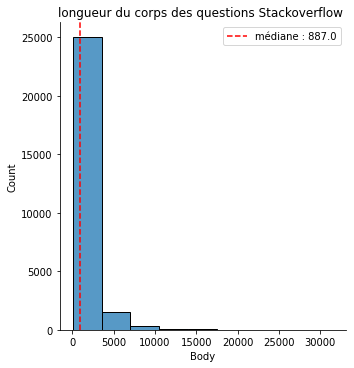

In [5]:
fig = plt.figure(figsize=(20, 12))
ax = sns.displot(x=body_length,binwidth=3500)

plt.axvline(df_init.Body.str.len().median() - df_init.Body.str.len().min(),
            color="r", linestyle='--',
            label="médiane : "+str(df_init.Body.str.len().median()))

plt.title("longueur du corps des questions Stackoverflow "
          )
plt.legend()
plt.show()

#==> la majeure partie des questions ont une longueur <5000

#je garde  les questions ayant un body <5000 caractères

In [6]:
df_init = df_init[df_init.Body.str.len() < 5000]
print('shape df ', df_init.shape)

shape df  (26054, 8)


#analyse tags

In [7]:
print('df[tags]',df_init['Tags'].head())

df[tags] 0                  <linux><bash><unix><coredump><tcsh>
1               <php><mysql><datetime><date><timezone>
2    <ios><cocoa-touch><uiview><uiviewcontroller><a...
3           <c#><.net><xml><wcf><configurationmanager>
4    <sql><database-design><tags><data-modeling><ta...
Name: Tags, dtype: object


In [8]:
# Replacer < > avec ,
df_init['Tags'] = df_init['Tags'].str.translate(str.maketrans({'<': '', '>': ','}))
df_init['Tags'] =df_init['Tags'].str[:-1]
print('remplacement de < > par , dans tags ',df_init['Tags'].head())

remplacement de < > par , dans tags  0                        linux,bash,unix,coredump,tcsh
1                     php,mysql,datetime,date,timezone
2    ios,cocoa-touch,uiview,uiviewcontroller,autola...
3                 c#,.net,xml,wcf,configurationmanager
4       sql,database-design,tags,data-modeling,tagging
Name: Tags, dtype: object


In [9]:
def count_split_tags(df, column, separator):

    list_words = []
    for word in df[column].str.split(separator):
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words

In [10]:
tags_list = count_split_tags(df=df_init, column='Tags', separator=',')
print("Le jeu de données compte {} tags.".format(tags_list.shape[0]))

Le jeu de données compte 12150 tags.


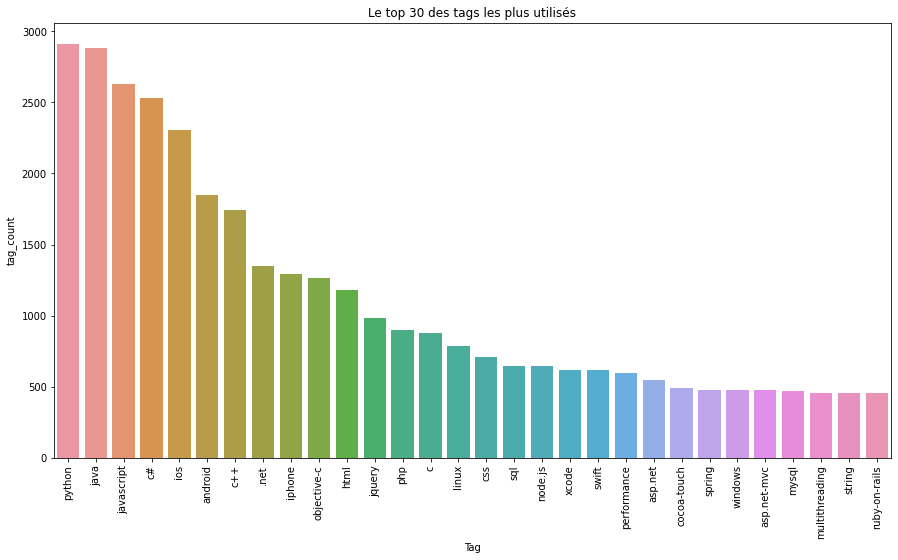

In [11]:
# Plot the results of splits
fig = plt.figure(figsize=(15, 8))
sns.barplot(data=tags_list.iloc[0:30, :],
            x=tags_list.iloc[0:30, :].index,
            y="tag_count")
plt.xticks(rotation=90)
plt.title("Le top 30 des tags les plus utilisés")
plt.show()

In [12]:
# Create a list of Tags and count the number
df_init['Tags_list'] = df_init['Tags'].str.split(',')
df_init['Tags_count'] = df_init['Tags_list'].apply(lambda x: len(x))

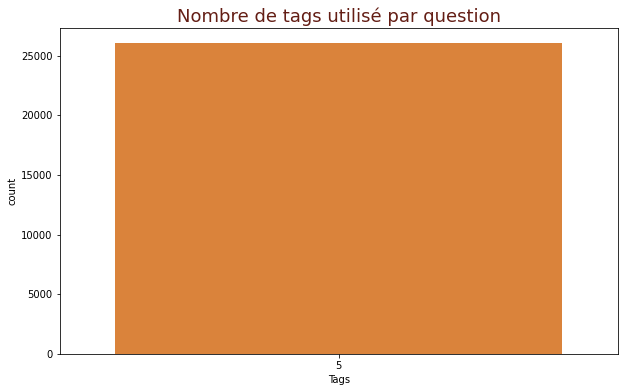

In [13]:
# Plot the result
fig = plt.figure(figsize=(10, 6))
ax = sns.countplot(x=df_init.Tags_count, color="#f48020")
ax.set_xlabel("Tags")
plt.title("Nombre de tags utilisé par question",
          fontsize=18, color="#641E15")
plt.show()

Filter les tags pour garder les plus utilisés 

In [14]:
def filter_tag(x, top_list):

    temp_list = []
    for item in x:
        if (item in top_list):
            #x.remove(item)
            temp_list.append(item)
    return temp_list

In [15]:
top_tags = list(tags_list.iloc[0:30].index)
df_init['Tags_list'] = df_init['Tags_list']\
                    .apply(lambda x: filter_tag(x, top_tags))
df_init['number_of_tags'] = df_init['Tags_list'].apply(lambda x : len(x))
df_init = df_init[df_init.number_of_tags > 0]
print("shape du jeu de données : {} questions.".format(df_init.shape[0]))

shape du jeu de données : 21583 questions.


#analyse de langue

In [16]:
def detect_lang(x):
    try:
        return detect(x)
    except:
        pass

df_init['short_body'] = df_init['Body'].apply(lambda x: x[0:100])
df_init['lang'] =df_init.short_body.apply(detect_lang)

print('langue détectée dans les questions ',pd.DataFrame(df_init.lang.value_counts()))
#l'anglais est majoritaire dans le jeu de données donc on supprime les autres langues pour simplifier l'analyse
df_init = df_init[df_init['lang']=='en']
print("shape du jeu de données après filtre sur la langue==en ", df_init.shape)

langue détectée dans les questions       lang
en  21298
ca     63
fr     61
pt     33
cy     28
ro     22
it     15
es     13
da     13
nl     13
no     10
af      4
sk      3
sv      2
de      2
et      1
vi      1
tl      1
shape du jeu de données après filtre sur la langue==en  (21298, 13)


#1.2 text preprocessing

In [17]:
#suppression des balises HTML qui sont dans le Body des questions
def remove_html(x):
    beautifulsoup = BeautifulSoup(x,"lxml")
    to_remove = beautifulsoup.findAll("code")
    for code in to_remove:
        code.replace_with(" ")
    return str(beautifulsoup)

df_init['Body'] = df_init['Body'].apply(remove_html)
# Delete all html tags
df_init['Body'] = [BeautifulSoup(text,"lxml").get_text() for text in df_init['Body']]
print("suppression balise html du body ", df_init['Body'].head(),'\n')

suppression balise html du body  0    I have a process in Linux that's getting a seg...
1    For those of us who use standard shared hostin...
2    Is it possible to change the constraints when ...
3    Using C# .NET 3.5 and WCF, I'm trying to write...
4    I've heard of a few ways to implement tagging;...
Name: Body, dtype: object 



In [18]:
def text_cleaner(x, nlp):
    # POS not in "NOUN", "PROPN"
    #x = remove_pos(nlp, x, pos_list)
    # Case lower
    x = x.lower()
    # Remove unicode characters
    x = x.encode("ascii", "ignore").decode()
    # Remove English contractions
    x = re.sub("\'\w+", '', x)
    # Remove ponctuation but not # (for C# for example)
    x = re.sub('[^\\w\\s#]', '', x)
    # Remove links
    x = re.sub(r'http*\S+', '', x)
    # Remove numbers
    x = re.sub(r'\w*\d+\w*', '', x)
    # Remove extra spaces
    x = re.sub('\s+', ' ', x)
    
    # Return cleaned text
    return x

<>:9: DeprecationWarning: invalid escape sequence '\w'
<>:17: DeprecationWarning: invalid escape sequence '\s'
<>:9: DeprecationWarning: invalid escape sequence '\w'
<>:17: DeprecationWarning: invalid escape sequence '\s'
C:\Users\Maroua.Missaoui\AppData\Local\Temp\ipykernel_21784\3666504052.py:9: DeprecationWarning: invalid escape sequence '\w'
  x = re.sub("\'\w+", '', x)
C:\Users\Maroua.Missaoui\AppData\Local\Temp\ipykernel_21784\3666504052.py:17: DeprecationWarning: invalid escape sequence '\s'
  x = re.sub('\s+', ' ', x)


In [19]:
 #clean body
nlp = spacy.load("en_core_web_sm")
pos_list=["NOUN","PROPN"]
def remove_pos(d):
    doc1= nlp(d)
    list_text_row = []
    for token in doc1:
        if(token.pos_ in pos_list) :
            list_text_row.append(token.text)
    join_text_row = " ".join(list_text_row)
    join_text_row = join_text_row.lower().replace("c #", "c#")
    return join_text_row

tqdm.pandas()
df_init['Body_cleaned'] = df_init["Body"].progress_apply(lambda x : text_cleaner(x, nlp))

print("spacy clean ", df_init['Body_cleaned'].head(20),'\n')
df_init['Body_cleaned'] = df_init["Body"].progress_apply(lambda x : remove_pos(x))
print("spacy keep noun ", df_init['Body_cleaned'].head(20),'\n')


c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecate

spacy clean  0     i have a process in linux that getting a segme...
1     for those of us who use standard shared hostin...
2     is it possible to change the constraints when ...
3     using c# net and wcf i trying to write out som...
4     i heard of a few ways to implement tagging usi...
5     following on from my previous question i have ...
6     i working on a projects which involves a lot o...
7     how do i go about specifying and using an enum...
8     we got a page with a ton of jquery approximate...
9     in the c and c programming languages what is t...
10    could somebody please do a rundown of how to p...
11    is there a simple way in net to quickly get th...
12    i currently writing an aspnet app from the ui ...
13    prior to c# generics everyone would code colle...
14    i have a img encoded that you can find here ho...
15    when performance is essential to an applicatio...
17    i am on centos bit and am trying to cause a bu...
18    which files should i include 

100%|██████████| 21298/21298 [05:55<00:00, 59.85it/s]

spacy keep noun  0            process linux segmentation fault core dump
1     packages godaddy network solutions datetime co...
2     constraints device example images portrait lan...
3     c# .net wcf wcf configuration client applicati...
4     ways tagging mapping table tagid itemid sense ...
5     question object model xml problem quelle surpr...
6     projects lot database % inserts % reads ratio ...
7                                     enum django model
8     page ton jquery lines b c maintenance nightmar...
9     c c++ programming languages difference angle b...
10    rundown config file .net c# kind check applica...
11    way .net protocol host port example url url ho...
12    app ui mvp architecture winforms separation co...
13    c# generics collections business objects colle...
14                              base64 img height width
15    performance application consideration array st...
17    centos bit buffer overflow program gdb output ...
18                             

In [20]:
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [21]:
df_init['Body_cleaned'] = df_init.Body_cleaned.apply(lemmatize_text)
print('\n')
print("lemma text ", df_init['Body_cleaned'])



lemma text  0        [process, linux, segmentation, fault, core, dump]
1        [package, godaddy, network, solution, datetime...
2        [constraint, device, example, image, portrait,...
3        [c#, .net, wcf, wcf, configuration, client, ap...
4        [way, tagging, mapping, table, tagid, itemid, ...
                               ...                        
27041    [sha-1, flutter, app, android, studio, google,...
27043    [database, survey, university, professor, pyth...
27044    [android, pie, request, encryption, default, s...
27045    [s, react, router, /cards, list, card, game, /...
27048    [document, warning, console, deprecationwarnin...
Name: Body_cleaned, Length: 21298, dtype: object


In [22]:
# Create a list of all tokens for Body
full_corpus = []
for i in df_init['Body_cleaned']:
    full_corpus.extend(i)

In [23]:
# Calculate distribition of words in Body token list
body_dist = nltk.FreqDist(full_corpus)
body_dist = pd.DataFrame(body_dist.most_common(2000),
                         columns=['Word', 'Frequency'])

c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\wordcloud\wordcloud.p

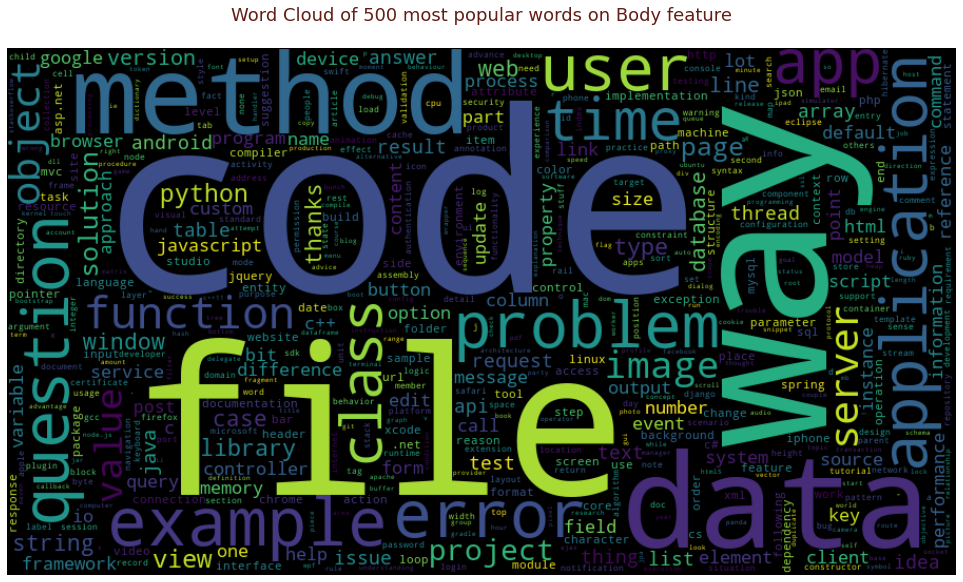

In [24]:
# Plot word cloud with tags_list (frequencies)
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(body_dist.set_index('Word').to_dict()['Frequency'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 most popular words on Body feature\n",
          fontsize=18, color="#641E16")
plt.show()

Nettoyage du titre de la question

In [25]:
def text_cleaner(x, nlp, pos_list, lang="english"):
    x = remove_pos(x)
    # Case normalization
    x = x.lower()
    # Remove unicode characters
    x = x.encode("ascii", "ignore").decode()
    # Remove English contractions
    x = re.sub("\'\w+", '', x)
    # Remove ponctuation but not # (for C# for example)
    x = re.sub('[^\\w\\s#]', '', x)
    # Remove links
    x = re.sub(r'http*\S+', '', x)
    # Remove numbers
    x = re.sub(r'\w*\d+\w*', '', x)
    # Remove extra spaces
    x = re.sub('\s+', ' ', x)
        
    # Tokenization
    x = nltk.tokenize.word_tokenize(x)
    # List of stop words in select language from NLTK
    stop_words = stopwords.words(lang)
    # Remove stop words
    x = [word for word in x if word not in stop_words 
         and len(word)>2]
    # Lemmatizer
    wn = nltk.WordNetLemmatizer()
    x = [wn.lemmatize(word) for word in x]
    
    # Return cleaned text
    return x


<>:8: DeprecationWarning: invalid escape sequence '\w'
<>:16: DeprecationWarning: invalid escape sequence '\s'
<>:8: DeprecationWarning: invalid escape sequence '\w'
<>:16: DeprecationWarning: invalid escape sequence '\s'
C:\Users\Maroua.Missaoui\AppData\Local\Temp\ipykernel_21784\529018159.py:8: DeprecationWarning: invalid escape sequence '\w'
  x = re.sub("\'\w+", '', x)
C:\Users\Maroua.Missaoui\AppData\Local\Temp\ipykernel_21784\529018159.py:16: DeprecationWarning: invalid escape sequence '\s'
  x = re.sub('\s+', ' ', x)


In [26]:
pos_list = ["NOUN","PROPN"]
tqdm.pandas()
df_init['Title_cleaned'] = df_init.Title.progress_apply(lambda x: text_cleaner(x,nlp,pos_list,"english"))

print("nettoyage titre ",df_init['Title_cleaned'].head(20))

100%|██████████| 21298/21298 [01:45<00:00, 201.15it/s]

nettoyage titre  0              [core, dump, linux, segmentation, fault]
1              [php, server, mysql, server, time, zone]
2     [autolayout, constraint, landscape, portrait, ...
3     [loading, system, servicemodel, configuration,...
4                          [sql, database, design, tag]
5                 [xml, serialization, inherited, type]
6                                      [myisam, innodb]
7                          [mysql, enum, django, model]
8                           [jquery, ajax, updatepanel]
9                                [difference, filename]
10                                  [config, file, net]
11                          [net, protocol, host, port]
12    [communicate, service, layer, message, error, ...
13     [list, businessobject, businessobjectcollection]
14                         [image, width, height, code]
15                          [performance, array, array]
17                                  [buffer, work, gdb]
18                          [gi

reconstituer le dataframe nettoyé

In [27]:
df_init = df_init[['Title_cleaned',
             'Body_cleaned',
             'Score',
             'Tags_list']]

df_init = df_init.rename(columns={'Title_cleaned': 'Title',
                            'Body_cleaned': 'Body',
                            'Tags_list': 'Tags'})

print ("dataset nettoye ", df_init.head(),"\n")

dataset nettoye                                                 Title  \
0           [core, dump, linux, segmentation, fault]   
1           [php, server, mysql, server, time, zone]   
2  [autolayout, constraint, landscape, portrait, ...   
3  [loading, system, servicemodel, configuration,...   
4                       [sql, database, design, tag]   

                                                Body  Score  \
0  [process, linux, segmentation, fault, core, dump]    237   
1  [package, godaddy, network, solution, datetime...     12   
2  [constraint, device, example, image, portrait,...     48   
3  [c#, .net, wcf, wcf, configuration, client, ap...     64   
4  [way, tagging, mapping, table, tagid, itemid, ...    324   

                 Tags  
0             [linux]  
1        [php, mysql]  
2  [ios, cocoa-touch]  
3          [c#, .net]  
4               [sql]   



In [28]:
df_init.to_csv('data/clean_data.csv',sep=';')

Transformation en matrix de TF-IDF features

In [29]:

df_init["Text"] = df_init["Title"] + df_init["Body"]
print("df_init[Text].head(3)", df_init["Text"].head(3))
X = df_init["Text"]
y = df_init["Tags"]

print( "X shape ", X.shape)
print("y shape ",y.shape)


vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=0.5,
                             min_df=0.001,
                             ngram_range=[1,3],
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words='english',
                             lowercase=False)

vectorizer.fit(X)
X_tf_idf = vectorizer.transform(X)

print('X_tf_idf.shape',X_tf_idf.shape,'\n')
print('y.shape',y.shape)

df_init[Text].head(3) 0    [core, dump, linux, segmentation, fault, proce...
1    [php, server, mysql, server, time, zone, packa...
2    [autolayout, constraint, landscape, portrait, ...
Name: Text, dtype: object
X shape  (21298,)
y shape  (21298,)
X_tf_idf.shape (21298, 3519) 

y.shape (21298,)


In [30]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of y: (21298, 30)


Gensim :Creating Bigram and Trigram Models

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [31]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [32]:
#min_count= minimum number of times it needs to occur to be considered a bigram 
bigram_phrase = gensim.models.Phrases(X, min_count=2, threshold=50)
trigram_phrase = gensim.models.Phrases(bigram_phrase[X], threshold=100) 

In [33]:
bigram_mod = gensim.models.phrases.Phraser(bigram_phrase)
trigram_mod = gensim.models.phrases.Phraser(trigram_phrase)

In [34]:
# Form Bigrams
data_words_bigrams = make_trigrams(X)
print (data_words_bigrams[0][0:50])

['core_dump', 'linux', 'segmentation_fault', 'process', 'linux', 'segmentation_fault', 'core_dump']


Create the Dictionary and Corpus needed for Topic Modeling

In [35]:
from gensim.models import TfidfModel
id2word=corpora.Dictionary(data_words_bigrams)
print(id2word)

Dictionary<36811 unique tokens: ['core_dump', 'linux', 'process', 'segmentation_fault', 'advice']...>


In [36]:
corpus=[id2word.doc2bow(text) for text in data_words_bigrams]

In [37]:
tfidf=TfidfModel(corpus,id2word=id2word)

In [38]:
corpus[0][0:20]

[(0, 2), (1, 2), (2, 1), (3, 2)]

if a word occurs below a certain frequency here the low_value variable , we assume that it is ubiquitous

In [39]:
low_value = 0.03 
words =[]
words_missing_in_tfidf = [ ] 
for i in range(0, len(corpus)): 
  bow = corpus[i] 
  low_value_words = [] 
  tfidf_ids =[id for id, value in tfidf[bow]] 
  bow_ids = [id for id, value in bow]
  low_value_words =[id for id, value in tfidf[bow] if value < low_value] 
  drops =low_value_words+words_missing_in_tfidf 
  for item in drops : 
    words.append(id2word[item] ) 
  words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] 

  new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
  corpus[i]=new_bow


Building the Topic Model LDA with gensim

In [40]:
lda_model =  gensim.models.LdaMulticore(corpus, 
                                   num_topics =9, 
                                   id2word = id2word,                                    
                                   workers = 4,
                                   passes=10)

In [41]:
#View the topics in LDA model
#For each topic, we will explore the words occuring in that topic and its relative weight
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.050*"file" + 0.021*"class" + 0.018*"application" + 0.017*"spring" + 0.014*"service" + 0.009*"project" + 0.008*"entity" + 0.008*"data" + 0.008*"solution" + 0.007*"configuration"


Topic: 1 
Words: 0.035*"string" + 0.028*"text" + 0.014*"model" + 0.013*"character" + 0.013*"line" + 0.012*"example" + 0.011*"python" + 0.011*"point" + 0.010*"code" + 0.010*"way"


Topic: 2 
Words: 0.067*"image" + 0.016*"app" + 0.015*"color" + 0.014*"background" + 0.013*"button" + 0.013*"view" + 0.012*"screen" + 0.012*"size" + 0.010*"text" + 0.009*"code"


Topic: 3 
Words: 0.049*"method" + 0.047*"object" + 0.043*"class" + 0.023*"java" + 0.014*"property" + 0.014*"key" + 0.013*"type" + 0.013*"way" + 0.012*"error" + 0.010*"example"


Topic: 4 
Words: 0.029*"android" + 0.021*"thread" + 0.013*"project" + 0.012*"process" + 0.011*"library" + 0.011*"task" + 0.011*"test" + 0.010*"error" + 0.010*"system" + 0.009*"version"


Topic: 5 
Words: 0.028*"view" + 0.022*"page" + 0.015*"function" + 0.015*"javasc

{'0': 'java'}

In [42]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz


c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.013932 -0.055113       1        1  17.733080
7     -0.132558  0.113847       2        1  14.477010
8      0.064093 -0.161639       3        1  13.325801
5      0.119645  0.075878       4        1  11.580166
4     -0.014420 -0.124332       5        1   9.767639
0     -0.075879 -0.114369       6        1   9.040117
3     -0.139419  0.024924       7        1   8.927433
2      0.245649  0.090789       8        1   8.264077
1     -0.081044  0.150015       9        1   6.884678, topic_info=           Term         Freq        Total Category  logprob  loglift
24        image  3573.000000  3573.000000  Default  30.0000  30.0000
41         file  8211.000000  8211.000000  Default  29.0000  29.0000
75        class  4101.000000  4101.000000  Default  28.0000  28.0000
89       object  3770.000000  3770.000000  Default  27.0000  27.0000
348      method  4791.000000  4791.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
103         xml   163.468280   612.992565   Topic9  -5.5759   1.3541
107  difference   216.733188  1787.333950   Topic9  -5.2939   0.5661
284      output   197.180947  1309.753468   Topic9  -5.3884   0.7824
40         data   180.110618  5150.755877   Topic9  -5.4790  -0.6775
41         file   173.570395  8211.268866   Topic9  -5.5160  -1.1808

[720 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
32376      7  0.942856      --disable
32         1  0.096271           .net
32         2  0.102689           .net
32         3  0.198961           .net
32         4  0.019254           .net
...      ...       ...            ...
14174      3  0.964456       yosemite
5616       3  0.957458        youtube
5616       4  0.022797        youtube
1842       3  0.950475  youtube_video
1842       8  0.045991  youtube_video

[2327 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 9, 6, 5, 1, 4, 3, 2])

**Compute LDA Coherence Score**


Intra-topic similarity – the similarity of words in the same topic.
Inter-topic similarity – the similarity of words across different topics.

==>maximize intra-topic and minimize inter-topic similarity. Also, by similarity, we imply the cosine similarity between words represented by word2vec embedding.



In [43]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=num_topics,
                                  workers=4)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [44]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=30, step=1)

In [45]:
limit=30; start=2; step=1;
x = range(start, limit, step)

In [46]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3675
Num Topics = 3  has Coherence Value of 0.3898
Num Topics = 4  has Coherence Value of 0.3904
Num Topics = 5  has Coherence Value of 0.4001
Num Topics = 6  has Coherence Value of 0.3819
Num Topics = 7  has Coherence Value of 0.3907
Num Topics = 8  has Coherence Value of 0.3738
Num Topics = 9  has Coherence Value of 0.3965
Num Topics = 10  has Coherence Value of 0.4014
Num Topics = 11  has Coherence Value of 0.3815
Num Topics = 12  has Coherence Value of 0.3909
Num Topics = 13  has Coherence Value of 0.387
Num Topics = 14  has Coherence Value of 0.3897
Num Topics = 15  has Coherence Value of 0.3848
Num Topics = 16  has Coherence Value of 0.3797
Num Topics = 17  has Coherence Value of 0.3959
Num Topics = 18  has Coherence Value of 0.388
Num Topics = 19  has Coherence Value of 0.3836
Num Topics = 20  has Coherence Value of 0.4002
Num Topics = 21  has Coherence Value of 0.3806
Num Topics = 22  has Coherence Value of 0.3898
Num Topics = 23  has Co

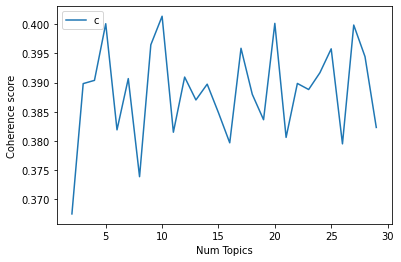

In [47]:
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Trouver le topic le plus dominant dans chaque question

In [48]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words_bigrams):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words_bigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show


C:\Users\Maroua.Missaoui\AppData\Local\Temp\ipykernel_21784\2118978604.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Maroua.Missaoui\AppData\Local\Temp\ipykernel_21784\2118978604.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [94]:
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4,0.8887,"android, thread, project, process, library, ta...","[core_dump, linux, segmentation_fault, process..."
1,1,6,0.6322,"user, server, data, request, database, table, ...","[php, server, mysql, server, time_zone, packag..."
2,2,2,0.6484,"image, app, color, background, button, view, s...","[autolayout_constraint, landscape_portrait, or..."
3,3,java,0.7134,"file, class, application, spring, service, pro...","[loading, system, servicemodel, configuration,..."
4,4,5,0.4146,"view, page, function, javascript, html, code, ...","[sql, database, design, tag, way, tagging, map..."
5,5,java,0.6024,"file, class, application, spring, service, pro...","[xml, serialization, inherited, type, question..."
6,6,6,0.7076,"user, server, data, request, database, table, ...","[myisam, innodb, project, lot, database, %, in..."
7,7,1,0.5636,"string, text, model, character, line, example,...","[mysql, enum, django, model, enum, django, model]"
8,8,5,0.4294,"view, page, function, javascript, html, code, ...","[jquery, ajax, updatepanel, page, ton, jquery,..."
9,9,1,0.7000,"string, text, model, character, line, example,...","[difference, filename, c_c++, programming_lang..."


In [93]:
df_dominant_topic['Dominant_Topic'].mask(df_dominant_topic['Dominant_Topic'] ==0 ,'java', inplace=True)

In [95]:
df_dominant_topic['Dominant_Topic'].mask(df_dominant_topic['Dominant_Topic'] ==1 ,'android', inplace=True)

In [96]:
df_dominant_topic['Dominant_Topic'].mask(df_dominant_topic['Dominant_Topic'] ==5 ,'javascript', inplace=True)

In [52]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=9, max_iter=50, learning_method='batch')
fit = lda.fit_transform(X_tf_idf)

In [59]:
tsne = TSNE(n_components=2)
%time X_tsne = tsne.fit_transform(fit)

c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: total: 13min 47s
Wall time: 1min 23s


In [68]:
colors = {'android':'r', 'java':'g', 'sql':'b'}

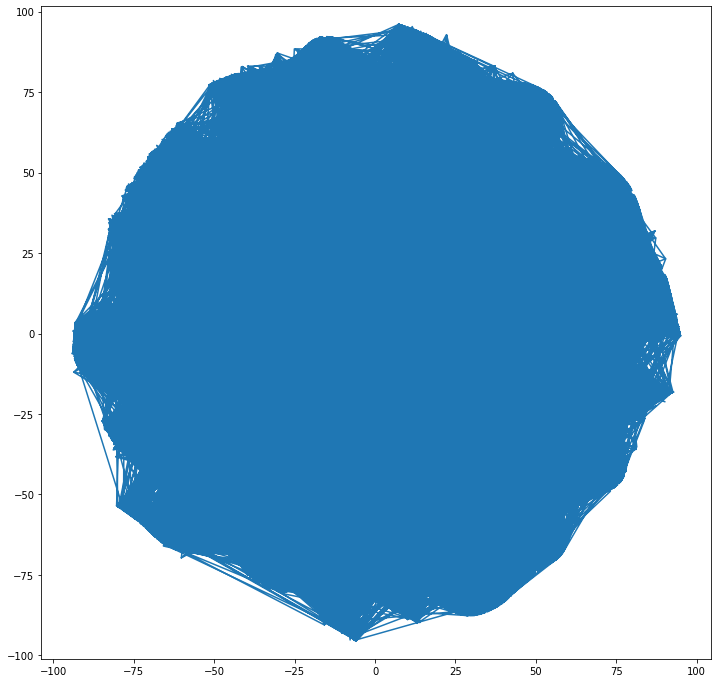

In [89]:
n=500
plt.figure(figsize=(12,12))
plt.plot(X_tsne[:,0], X_tsne[:,1])
plt.axis('equal')
plt.show()

NMF topic modeling

In [ ]:
def plot_top_words(model, feature_names, 
                   n_top_words, nb_topic_plot, title):

    rows = int(nb_topic_plot/6)
    fig, axes = plt.subplots(rows, 6, 
                             figsize=(30, rows*10), 
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_topic_plot):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36, color="#641E16")

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


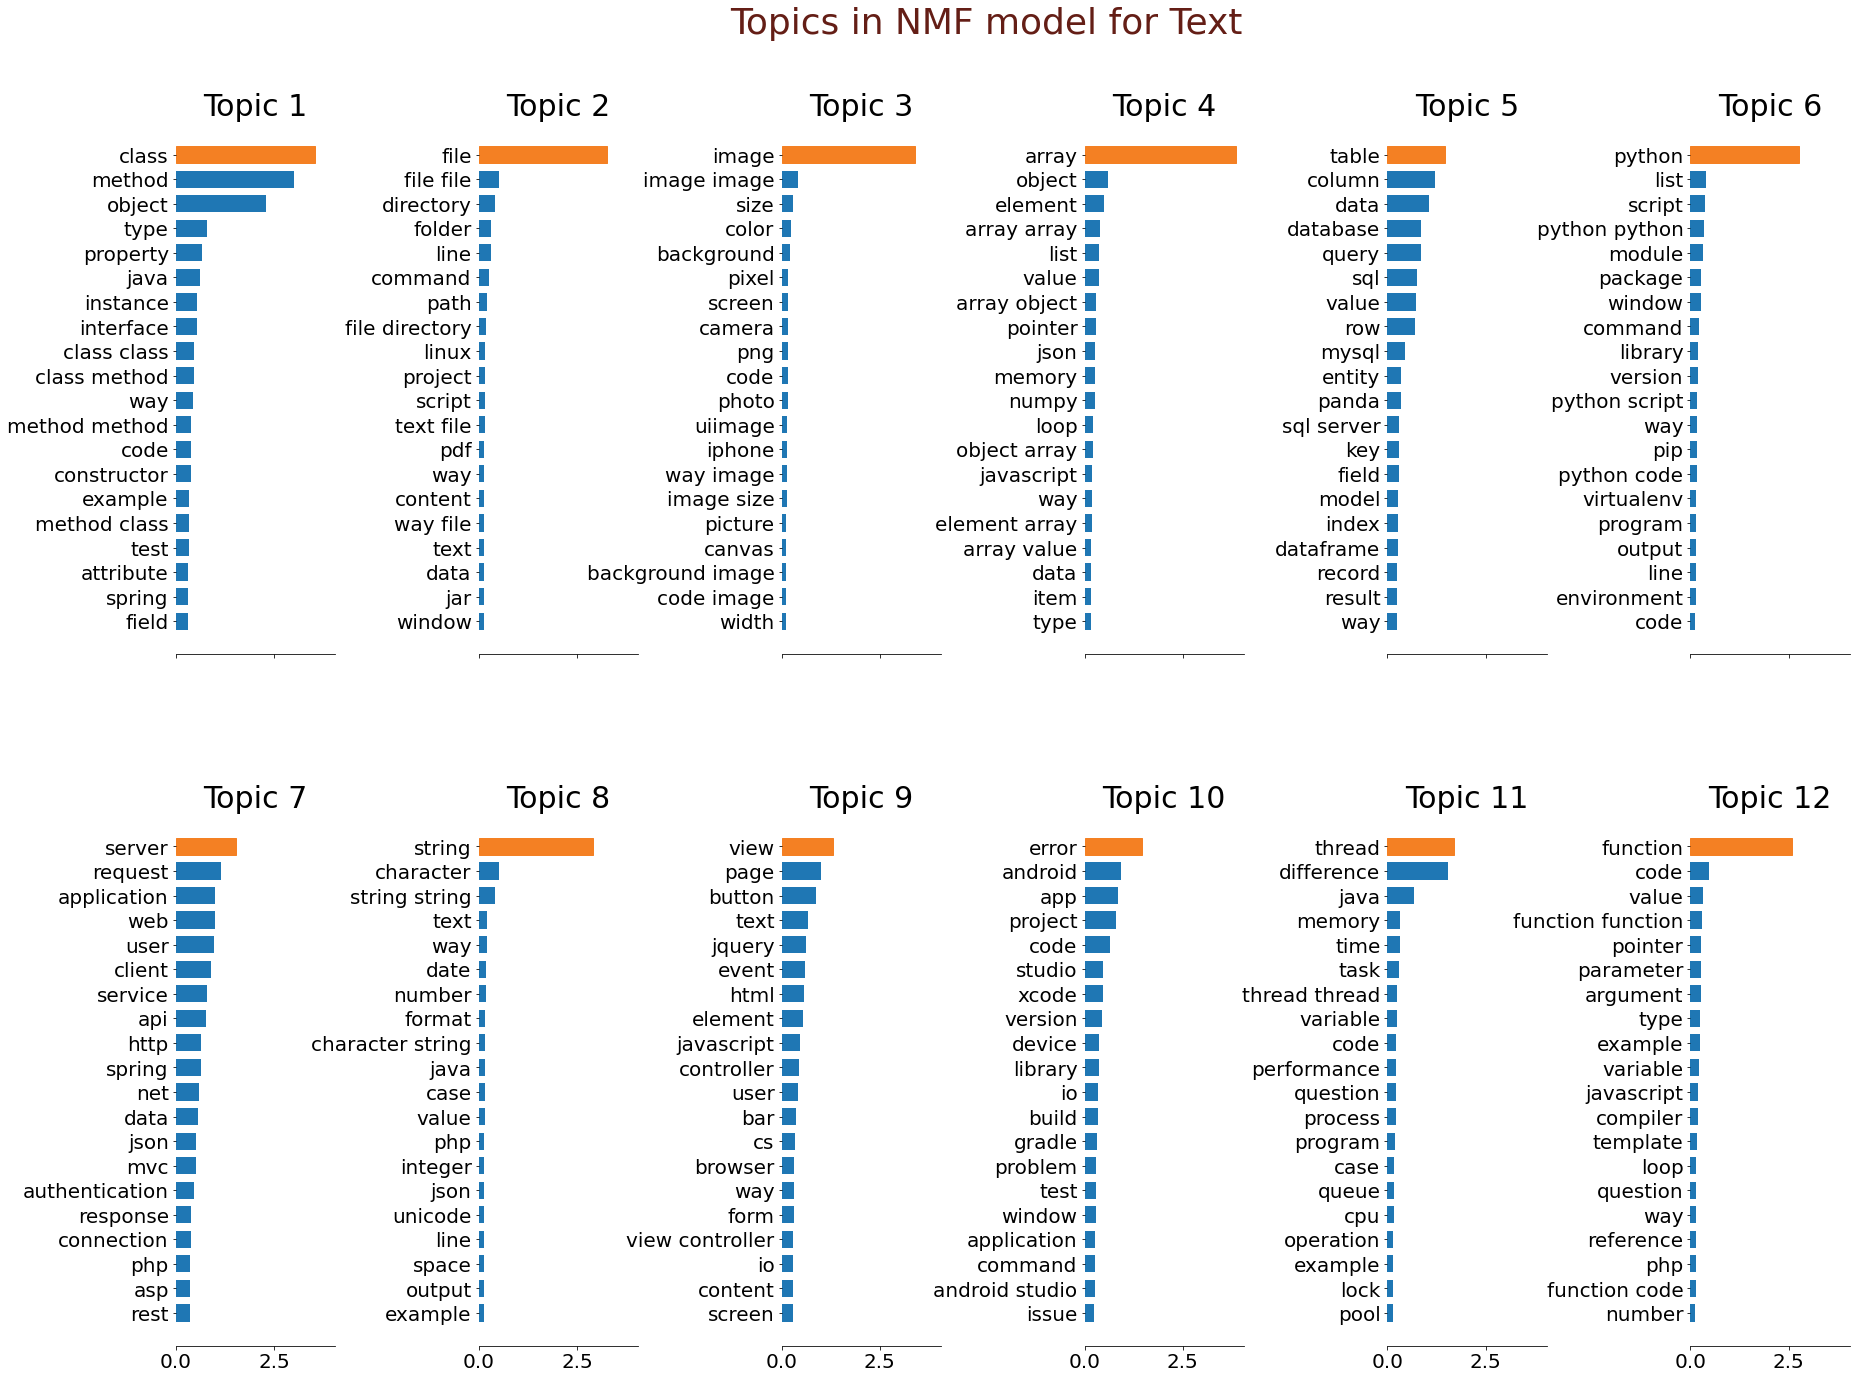

In [ ]:
n_topics = 12


# Initializing the NMF
full_nmf = NMF(n_components=n_topics,
               init='nndsvd',
               random_state=10)

# Fit NMF on Body vectorized
full_nmf.fit(X_tf_idf)


# Plot the 12 first topics
ff_feature_names = vectorizer.get_feature_names()
plot_top_words(full_nmf, ff_feature_names, 20, 12,
               'Topics in NMF model for Text')

Predict topic distribution for unseen text with LDA

In [ ]:
test_text=pd.DataFrame({'text':['Is there any way to update data from a sql database from a api using android studio with java?']})
test_text

,text
0,Is there any way to update data from a sql dat...


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [ ]:

new_text_corpus =  id2word.doc2bow(test_text['text'][0].split())
lda_model[new_text_corpus]

[(0, 0.53726244),
 (1, 0.007952701),
 (2, 0.007954771),
 (3, 0.007953036),
 (4, 0.007953438),
 (5, 0.21981733),
 (6, 0.19518432),
 (7, 0.007965317),
 (8, 0.007956598)]

In [ ]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y_binarized,
                                                    test_size=0.3, random_state=10)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))


X_train shape : (14901, 3516)
X_test shape : (6387, 3516)
y_train shape : (14901, 30)
y_test shape : (6387, 30)


Baseline model : logistic regression sans réduction de dimensions

In [ ]:
# Initialize Logistic Regression with OneVsRest
#penalty — Specify the norm of the penalty.
#C — Inverse of regularization strength; smaller values specify stronger regularization.
param_logit = {"estimator__C": [2,3,4,5,8,10, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__solver": ["liblinear"]}

logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              return_train_score = True
                              )
best=logit_cv.fit(X_train, y_train)

best.best_params_

best.best_score_

y_pred_logit=logit_cv.predict(X_test)

#to do add label 
print(classification_report(y_test,y_pred_logit))

jaccardscore=jaccard_score(y_test, y_pred_logit, average='weighted')
print("score jaccard de logit ", jaccardscore)

# Inverse transform
y_test_pred_logit_inversed = multilabel_binarizer.inverse_transform(y_pred_logit)
y_test_inversed = multilabel_binarizer.inverse_transform(y_test)

print(" Logistic reg model , 2 first tags : actual vs predicted")

print("Actual:", y_test_inversed[0:3])
print("Predicted:", y_test_pred_logit_inversed[0:3])


              precision    recall  f1-score   support

           0       0.58      0.31      0.41       401
           1       0.95      0.81      0.87       576
           2       0.57      0.31      0.40       156
           3       0.78      0.49      0.60       148
           4       0.53      0.30      0.38       252
           5       0.67      0.48      0.56       731
           6       0.76      0.44      0.55       531
           7       0.38      0.08      0.13       150
           8       0.78      0.56      0.65       203
           9       0.68      0.43      0.52       345
          10       0.74      0.60      0.66       691
          11       0.63      0.31      0.42       407
          12       0.85      0.64      0.73       856
          13       0.81      0.58      0.68       769
          14       0.81      0.58      0.68       257
          15       0.73      0.49      0.59       229
          16       0.73      0.45      0.55       137
          17       0.88    

c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


logistic regression with dimension reduction using SVD 

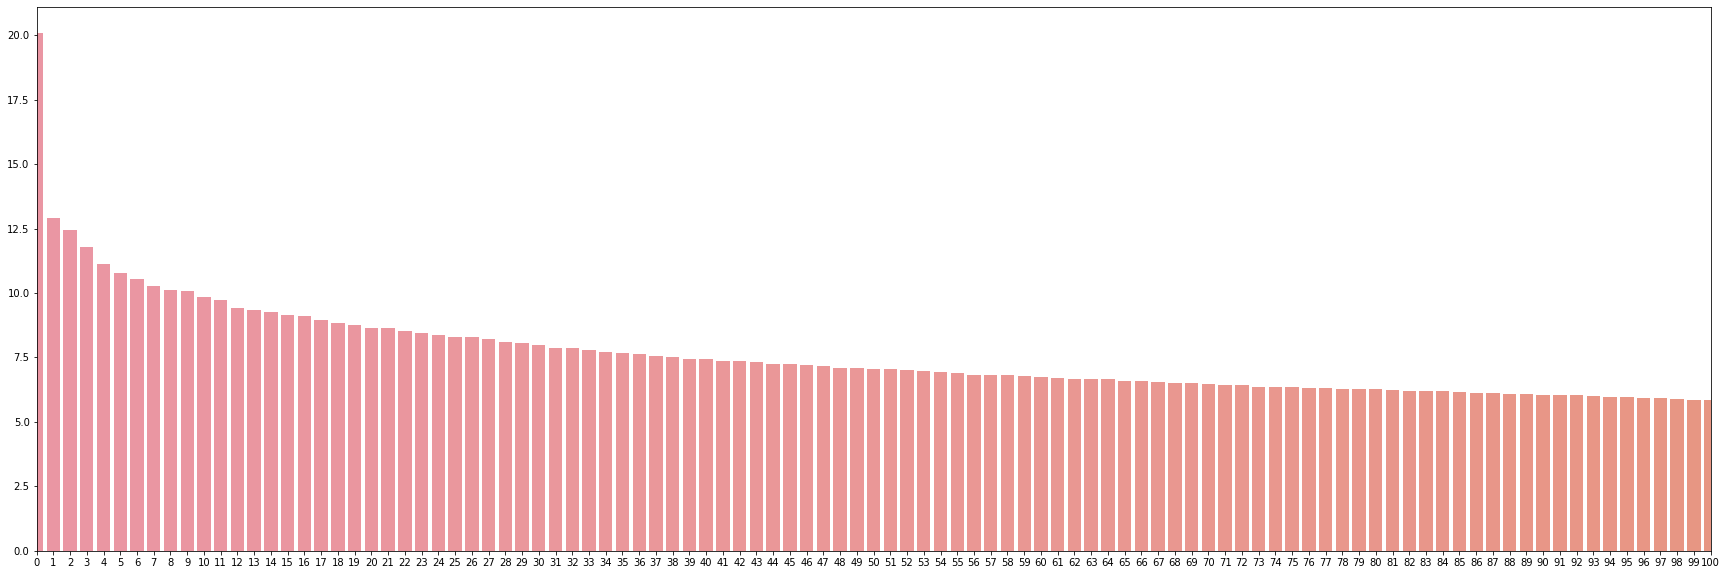

In [ ]:
lsa_obj = TruncatedSVD(n_components=2000, n_iter=100, random_state=42)
tfidf_lsa_data = lsa_obj.fit_transform(X_tf_idf)
Sigma = lsa_obj.singular_values_
V_T = lsa_obj.components_.T
plt.figure(figsize=(30,10))
sh=sns.barplot(x=list(range(len(Sigma))), y = Sigma)
sh.set_xlim(0, 100)
plt.show()




In [ ]:
var_explained = lsa_obj.explained_variance_ratio_.sum()
var_explained

0.9240101636432719

In [ ]:

X_train_lsa, X_test_lsa, y_train, y_test = train_test_split(tfidf_lsa_data, y_binarized,
                                                    test_size=0.3, random_state=10)
print("X_train shape : {}".format(X_train_lsa.shape))
print("X_test shape : {}".format(X_test_lsa.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))
#Using our latent components in our modelling task for logistic regression
#Modèle Logistic regression ( OvR)
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [2,3,4,5,8,10, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__solver": ["liblinear"]}

logit_lsa__cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              return_train_score = True
                              )
best=logit_lsa__cv.fit(X_train_lsa, y_train)

best.best_params_

best.best_score_

y_pred_logit=logit_lsa__cv.predict(X_test_lsa)

#to do add label 
print("logit_lsa classification_report ",classification_report(y_test,y_pred_logit))

score_jaccard_lsa=jaccard_score(y_test, y_pred_logit, average='weighted')
print(" score jaccard de logit avec lsa ", score_jaccard_lsa)

# Inverse transform
y_test_pred_logit_inversed_lsa = multilabel_binarizer.inverse_transform(y_pred_logit)
y_test_inversed_lsa = multilabel_binarizer.inverse_transform(y_test)

print(" Logistic reg model with lsa , 2 first tags : actual vs predicted")

print("Actual:", y_test_inversed_lsa[0:3])
print("Predicted:", y_test_pred_logit_inversed_lsa[0:3])

X_train shape : (14901, 2000)
X_test shape : (6387, 2000)
y_train shape : (14901, 30)
y_test shape : (6387, 30)
logit_lsa classification_report                precision    recall  f1-score   support

           0       0.59      0.32      0.42       401
           1       0.95      0.81      0.87       576
           2       0.54      0.32      0.40       156
           3       0.78      0.47      0.58       148
           4       0.55      0.31      0.39       252
           5       0.67      0.51      0.58       731
           6       0.75      0.46      0.57       531
           7       0.32      0.07      0.12       150
           8       0.78      0.56      0.65       203
           9       0.64      0.41      0.50       345
          10       0.74      0.62      0.68       691
          11       0.62      0.31      0.42       407
          12       0.82      0.65      0.73       856
          13       0.79      0.60      0.68       769
          14       0.82      0.59      0.69 

c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest classifier

In [ ]:
param_rfc = {"estimator__max_depth": [10, 15,20],
             "estimator__max_features" : ['auto', 'sqrt'],
             "estimator__class_weight": ["balanced"]}

rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            cv=2,
                            scoring="f1_weighted",
                            return_train_score = True,
                            verbose=3)

rfc_cv.fit(X_train, y_train)

print("Best params for RandomForestClassifier")

rfc_best_params = rfc_cv.best_params_
print(rfc_best_params)

rfc_best_params

rfc_best = {}
for i, j in rfc_best_params.items():
    rfc_best[i.replace("estimator__","")] =j

# Predict
y_test_pred_labels_tfidf_rfc = rfc_cv.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer.inverse_transform(y_test_pred_labels_tfidf_rfc)


print("Random Forest : Print  predicted Tags vs actual Tags")
print("True:", y_test_inversed[0:4])
print("Predicted:", y_test_pred_inversed_rfc[0:4])


jaccard_score(y_test, y_test_pred_labels_tfidf_rfc , average='weighted')

print(classification_report(y_test,y_test_pred_labels_tfidf_rfc))


Fitting 2 folds for each of 6 candidates, totalling 12 fits


c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=10, estimator__max_features=auto;, score=(train=0.751, test=0.609) total time=  11.7s


c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

[CV 2/2] END estimator__class_weight=balanced, estimator__max_depth=10, estimator__max_features=auto;, score=(train=0.756, test=0.622) total time=  11.3s
[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=10, estimator__max_features=sqrt;, score=(train=0.759, test=0.613) total time=  11.2s
[CV 2/2] END estimator__class_weight=balanced, estimator__max_depth=10, estimator__max_features=sqrt;, score=(train=0.756, test=0.617) total time=  11.1s


c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=15, estimator__max_features=auto;, score=(train=0.826, test=0.618) total time=  16.9s


c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

[CV 2/2] END estimator__class_weight=balanced, estimator__max_depth=15, estimator__max_features=auto;, score=(train=0.823, test=0.623) total time=  15.1s
[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=15, estimator__max_features=sqrt;, score=(train=0.824, test=0.619) total time=  15.0s
[CV 2/2] END estimator__class_weight=balanced, estimator__max_depth=15, estimator__max_features=sqrt;, score=(train=0.825, test=0.623) total time=  14.6s


c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=20, estimator__max_features=auto;, score=(train=0.870, test=0.610) total time=  18.7s


c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in

[CV 2/2] END estimator__class_weight=balanced, estimator__max_depth=20, estimator__max_features=auto;, score=(train=0.874, test=0.606) total time=  18.7s
[CV 1/2] END estimator__class_weight=balanced, estimator__max_depth=20, estimator__max_features=sqrt;, score=(train=0.873, test=0.609) total time=  18.6s
[CV 2/2] END estimator__class_weight=balanced, estimator__max_depth=20, estimator__max_features=sqrt;, score=(train=0.874, test=0.612) total time=  18.5s
Best params for RandomForestClassifier
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 15, 'estimator__max_features': 'sqrt'}
Random Forest : Print  predicted Tags vs actual Tags
True: [('php', 'sql'), ('jquery', 'php'), ('html', 'ios', 'iphone'), ('javascript',)]
Predicted: [('cocoa-touch', 'iphone', 'objective-c', 'php'), ('javascript', 'jquery', 'php'), ('html', 'ios', 'iphone', 'javascript'), ('javascript',)]
              precision    recall  f1-score   support

           0       0.42      0.57      0.48       

c:\Users\Maroua.Missaoui\.virtualenvs\ML_P5_MISSAOUI_Maroua-qMWVZngN\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Export fitted model and Preprocessor

In [ ]:
joblib.dump(logit_cv,'logisticreg_nlp_model.pkl')
joblib.dump(vectorizer,'tfidf_vectorizer.pkl')
joblib.dump(multilabel_binarizer,'multilabel_binarizer.pkl')


['multilabel_binarizer.pkl']